## Logit Model
---


In [1]:
%matplotlib inline
import numpy as np
import scipy.stats as st
import pandas as pd
import matplotlib.pyplot as plt
import pymc3 as pm
from IPython.display import display
# workaround for Theano compilation errors
import theano
theano.config.gcc.cxxflags = '-Wno-c++11-narrowing'
# ignore warnings
import warnings 
warnings.simplefilter('ignore')

The following cell generates data from 

$$
 y_i = \begin{cases}
 1, & \text{with probability}\quad \mu_i; \\
 0, & \text{with probability}\quad 1-\mu_i.
 \end{cases}
$$

$$
 \log\frac{\mu_i}{1-\mu_i} = 0.5 x_{1i} - 0.5 x_{2i},\quad i=1,\dots,500.
$$


In [2]:
n = 500
np.random.seed(99)
x1 = st.uniform.rvs(loc=-np.sqrt(3.0), scale=2.0*np.sqrt(3.0), size=n)
x2 = st.uniform.rvs(loc=-np.sqrt(3.0), scale=2.0*np.sqrt(3.0), size=n)
q = st.logistic.cdf(0.5*x1 - 0.5*x2)
y = st.bernoulli.rvs(q)
X = np.stack((np.ones(n), x1, x2), axis=1)

In [3]:
n, k = X.shape
b0 = np.zeros(k)
A0 = 0.01 * np.eye(k)
logit_model = pm.Model()
with logit_model:
    b = pm.MvNormal('b', mu=b0, tau=A0, shape=k)
    idx = pm.math.dot(X, b)
    likelihood = pm.Bernoulli('y', logit_p=idx, observed=y)
n_draws = 5000
n_chains = 4
n_tune = 1000
with logit_model:
    trace = pm.sample(draws=n_draws, chains=n_chains, tune=n_tune, random_seed=123)
sim_param = dict([('$\\beta_{:d}$'.format(index), trace['b'][:, index]) for index in range(k)])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b]
Sampling 4 chains, 0 divergences: 100%|██████████| 24000/24000 [00:16<00:00, 1465.99draws/s]


In [4]:
display(pm.summary(trace))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
b[0],-0.081,0.095,-0.259,0.098,0.001,0.001,25908.0,15016.0,25919.0,13865.0,1.0
b[1],0.422,0.099,0.243,0.612,0.001,0.000,24649.0,23939.0,24647.0,14499.0,1.0
b[2],-0.487,0.098,-0.670,-0.306,0.001,0.000,26290.0,25088.0,26274.0,15475.0,1.0


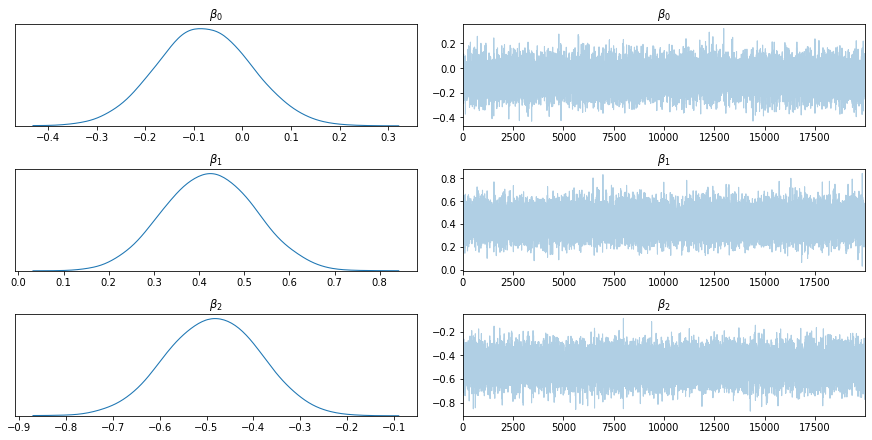

In [5]:
pm.traceplot(sim_param)
plt.show()

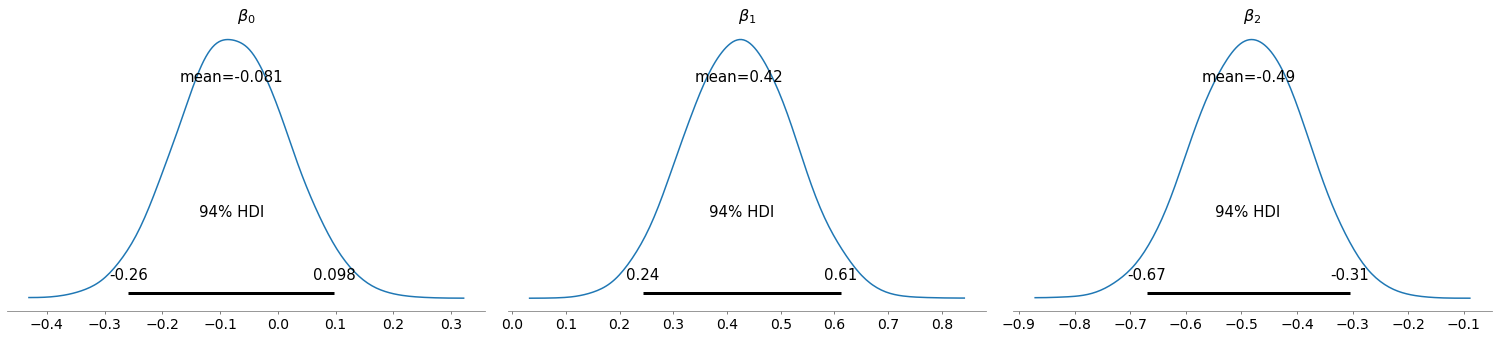

In [6]:
pm.plot_posterior(sim_param, kind='kde', point_estimate='mean')
plt.show()